<div class="alert alert-warning">

***Задание***

В рамках этого итогового задания мы будем прогнозировать сердечную недостаточность.

Плана по выполнению задания не будет. 
Но есть несколько требований: 
- оберните весь конвейер преобразований в Pipeline
- подберите оптимальный вариант прогнозной модели с помощью GridSearchCV
- примените обученный на тренировочных данных конвейер к тестовым данным, никак не предобрабатывая их, а лишь загрузив из файла и отделив целевой признак от остальных
- получите на тестовой части качество не ниже 0.87 по метрике ROCAUC\
Пояснение: если пропуски в новых данных и будут, то только в тех колонках, где они есть в тренировочной части.

Информация по признакам:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from scipy import stats
from sklearn.base import TransformerMixin, BaseEstimator, OneToOneFeatureMixin

from xgboost import XGBClassifier
from phik.report import plot_correlation_matrix
from phik import report
# pd.set_option("display.max_columns", None)

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['font.size'] = 10
plt.style.use('dark_background')
param_plt = {"linewidth": 3, "color": "red", "linestyle": "dotted"}

## Загрузка данных

In [2]:
try:
    df_train = pd.read_csv("heart_adapt_train.csv", delimiter=",")
    df_test = pd.read_csv("heart_adapt_test.csv", delimiter=",")
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


In [4]:
df_train.columns = df_train.columns.str.lower()
df_train.columns

Index(['age', 'sex', 'chestpaintype', 'restingbp', 'cholesterol', 'fastingbs',
       'restingecg', 'maxhr', 'exerciseangina', 'oldpeak', 'st_slope',
       'heartdisease'],
      dtype='object')

In [5]:
print(f"Количество дубликатов: {df_train[df_train.duplicated()].shape[0]}")

Количество дубликатов: 0


In [6]:
df_train.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,74.0,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1


Итого, в датасете 12 столбцов (7 числовых и 5 категориальных) и 589 строк.

## Описательный анализ данных

Рассмотрим числовые столбцы.

In [7]:
num_features = df_train.select_dtypes(include="number").drop(columns=['heartdisease'])

In [8]:
df_train.describe()

,age,restingbp,cholesterol,fastingbs,maxhr,oldpeak,heartdisease
count,533.000000,588.000000,462.000000,589.000000,589.000000,589.000000,589.000000
mean,54.195122,133.358844,245.632035,0.258065,134.893039,0.937521,0.646859
std,9.532661,18.851852,58.599184,0.437942,24.942596,1.071318,0.478352
min,28.000000,80.000000,85.000000,0.000000,63.000000,-2.600000,0.000000
25%,48.000000,120.000000,209.000000,0.000000,117.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,0.000000,135.000000,0.800000,1.000000
75%,61.000000,144.000000,279.750000,1.000000,154.000000,1.600000,1.000000
max,77.000000,200.000000,603.000000,1.000000,195.000000,5.000000,1.000000


Посмотрим бинарный столбец.

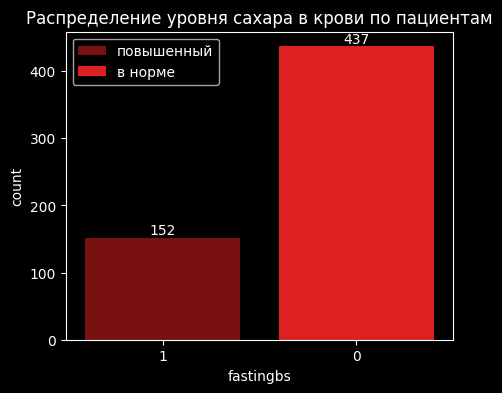

In [9]:
mask = df_train.fastingbs==1
plt.title("Распределение уровня сахара в крови по пациентам")
ax_1 = sns.countplot(x=df_train.loc[mask].fastingbs, color="darkred", stat="count")
ax_2 = sns.countplot(x=df_train.loc[~mask].fastingbs, color="red", stat="count")
ax_1.bar_label(ax_1.containers[0])
ax_2.bar_label(ax_2.containers[1])
plt.legend(labels=["повышенный", "в норме"])
plt.show()

Видно, что среди пациентов людей с повышенным сахаром меньше в  3 раза, чем с нормальным.\
Посмотрим другие числовые признаки.

In [10]:
var_ = num_features.var().round(1).to_frame(name="var")
unique = num_features.nunique().to_frame(name="unique")
pd.concat([var_, unique], join="outer", axis=1).T

,age,restingbp,cholesterol,fastingbs,maxhr,oldpeak
var,90.9,355.4,3433.9,0.2,622.1,1.1
unique,49.0,61.0,189.0,2.0,112.0,47.0


In [11]:
IQR = pd.DataFrame(
    {
        "min": num_features.min(),
        "max": num_features.max(),
        "Q1": num_features.quantile(0.25),
        "Q3": num_features.quantile(0.75),
    }
)
IQR["iqr"] = IQR["Q3"] - IQR["Q1"]
IQR["outlier-"] = IQR["Q3"] - IQR["iqr"] * 1.5
IQR["outlier+"] = IQR["Q1"] + IQR["iqr"] * 1.5
IQR.drop(columns=["Q1", "Q3", "iqr"], axis=1, inplace=True)
IQR.T

,age,restingbp,cholesterol,fastingbs,maxhr,oldpeak
min,28.0,80.0,85.000,0.0,63.0,-2.6
max,77.0,200.0,603.000,1.0,195.0,5.0
outlier-,41.5,108.0,173.625,-0.5,98.5,-0.8
outlier+,67.5,156.0,315.125,1.5,172.5,2.4


Посмотрим на выбросы визуально.

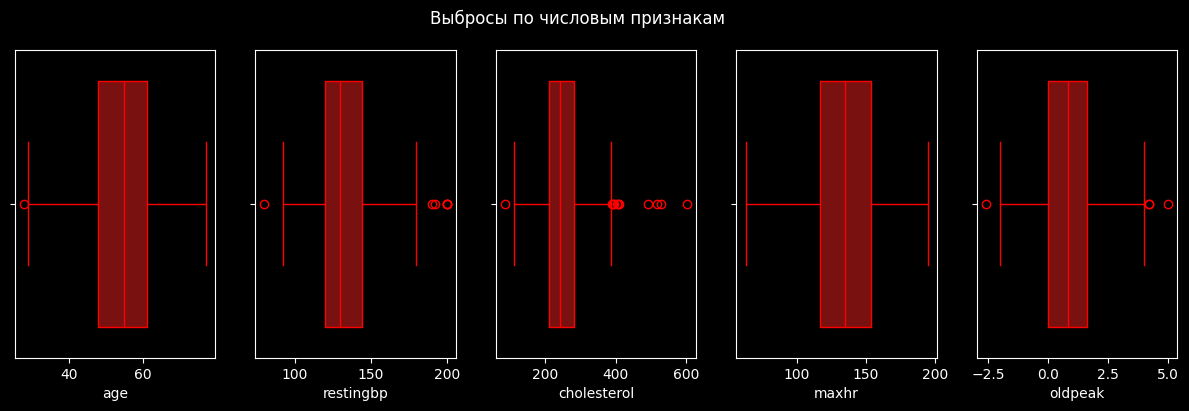

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle("Выбросы по числовым признакам")
i = 0

for feat in num_features.drop(columns=["fastingbs"]):
    sns.boxplot(num_features, x=feat, ax=ax[i], color="darkred", linecolor="red")
    i += 1

plt.show()

In [13]:
df_train.loc[df_train.restingbp > 190]

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
286,64.0,F,ASY,200.0,NaN,0,Normal,140,Y,1.0,Flat,1
335,61.0,M,NAP,200.0,NaN,1,ST,70,N,0.0,Flat,1
471,54.0,M,ATA,192.0,283.0,0,LVH,195,N,0.0,Up,1
483,54.0,M,ASY,200.0,198.0,0,Normal,142,Y,2.0,Flat,1
554,56.0,F,ASY,200.0,288.0,1,LVH,133,Y,4.0,Down,1


Видно, что это не выбросы, такое давление реальное и эти люди имеют проблемы с сердцем.

In [14]:
df_train.loc[df_train.restingbp < 100]

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
48,NaN,M,ASY,95.0,NaN,1,Normal,182,N,0.7,Down,1
190,51.0,M,NAP,94.0,227.0,0,Normal,154,Y,0.0,Up,0
205,38.0,M,ASY,92.0,117.0,0,Normal,134,Y,2.5,Flat,1
233,34.0,M,ATA,98.0,220.0,0,Normal,150,N,0.0,Up,0
269,32.0,M,TA,95.0,NaN,1,Normal,127,N,0.7,Up,1
284,40.0,M,ASY,95.0,NaN,1,ST,144,N,0.0,Up,1
355,NaN,M,ASY,80.0,NaN,0,Normal,141,Y,2.0,Down,0
524,51.0,M,ASY,95.0,NaN,1,Normal,126,N,2.2,Flat,1


Низкое давление тоже имеет место быть, и эти люди также могут иметь проблемы с сердцем.

In [15]:
df_train.loc[df_train.oldpeak < 0].shape[1]

12

Сложно сказать, являются ли эти значения выбросами, так как не известна шкала измерений

In [16]:
df_train.loc[(df_train.cholesterol < 100)| (df_train.cholesterol > 400)]

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
75,56.0,M,ASY,120.0,85.0,0,Normal,140,N,0.0,Up,0
96,56.0,F,ASY,134.0,409.0,0,LVH,150,Y,1.9,Flat,1
123,32.0,M,ASY,118.0,529.0,0,Normal,130,N,0.0,Flat,1
182,54.0,M,ASY,130.0,603.0,1,Normal,125,Y,1.0,Flat,1
193,63.0,F,ASY,150.0,407.0,0,LVH,154,N,4.0,Flat,1
197,44.0,M,ASY,135.0,491.0,0,Normal,135,N,0.0,Flat,1
312,53.0,M,NAP,145.0,518.0,0,Normal,130,N,0.0,Flat,1
512,52.0,M,ASY,140.0,404.0,0,Normal,124,Y,2.0,Flat,1


И те и другие значения имеют место быть, из этих данных видно, что очень ысокий холестерин = проблемы с сердцем.

Вывод:
- В признаках есть 1 бинарный столбец: fastingbs (75% значений - 0);
- Столбец age скорее всего нормально распределен, возраст от 28 до 77 лет в данных, есть пропуски;
- Столбец restingbp (давление) тоже похож на нормальное распределение, данные от 80 до 200, есть небольшие выбросы;
- Столбец cholesterol есть выбросы и пропуски;
- Столбец maxhr распределен нормально;
- Столбец oldpeak содержит отрицательные значения, есть небольшие выбросы.\
В целом, в числовых данных много уникальных значений и почти все столбцы содержат выбросы.

Посмотрим категориальные признаки.

In [17]:
cat_features = df_train.select_dtypes(include="object")

In [18]:
df_train.describe(include="object")

,sex,chestpaintype,restingecg,exerciseangina,st_slope
count,589,589,589,589,589
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,477,348,345,325,325


In [19]:
for col in cat_features:
    print(
        f"Столбец {col}\n{100* (df_train[col].value_counts()).round(5)}",
        end="\n\n",
    )

Столбец sex
M    47700
F    11200
Name: sex, dtype: int64

Столбец chestpaintype
ASY    34800
NAP    11700
ATA     9600
TA      2800
Name: chestpaintype, dtype: int64

Столбец restingecg
Normal    34500
LVH       12600
ST        11800
Name: restingecg, dtype: int64

Столбец exerciseangina
N    32500
Y    26400
Name: exerciseangina, dtype: int64

Столбец st_slope
Flat    32500
Up      22400
Down     4000
Name: st_slope, dtype: int64



Посмотрим на категориальные столбцы визульально.

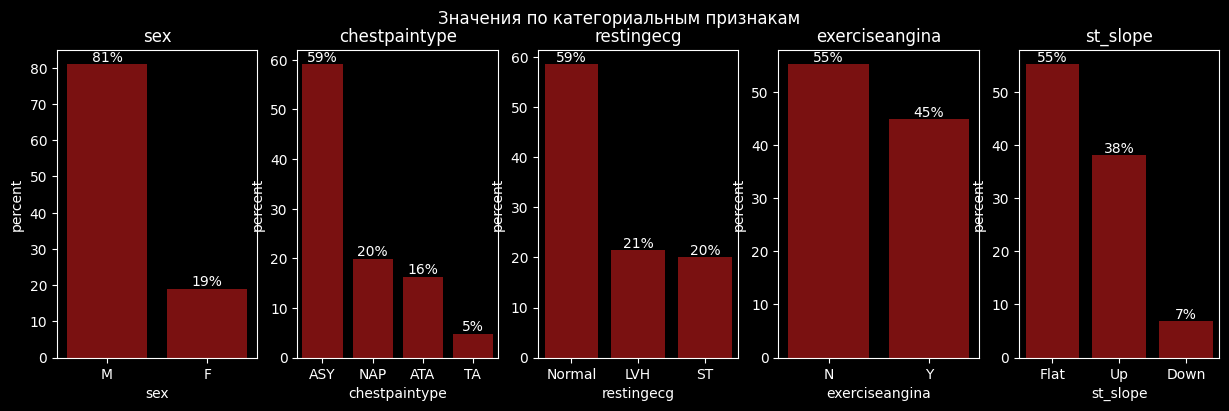

In [20]:
fig, ax = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle("Значения по категориальным признакам")
i = 0

for feat in cat_features:
    pl = sns.countplot(
        cat_features,
        x=feat,
        color="darkred",
        ax=ax[i],
        stat="percent",
        order=cat_features[feat].value_counts().index,
    )
    ax[i].set_title(feat)
    pl.bar_label(pl.containers[0], fmt="%.f%%")
    i += 1
plt.show()

 В столбцах exerciseangina и st_slope есть значение с одинаковой долей. Проверим, есть ли у них связь.

In [21]:
crosstab = pd.crosstab(df_train.exerciseangina, df_train.st_slope)
print(f'P-value = {stats.chi2_contingency(crosstab)[1]}')
crosstab

P-value = 8.472372477281624e-27


st_slope,Down,Flat,Up
exerciseangina,,,
N,10,128,187
Y,30,197,37


Небольшая корреляция между признаками есть.

Посмотрим на таргет.

In [22]:
df_train.heartdisease.value_counts()

1    381
0    208
Name: heartdisease, dtype: int64

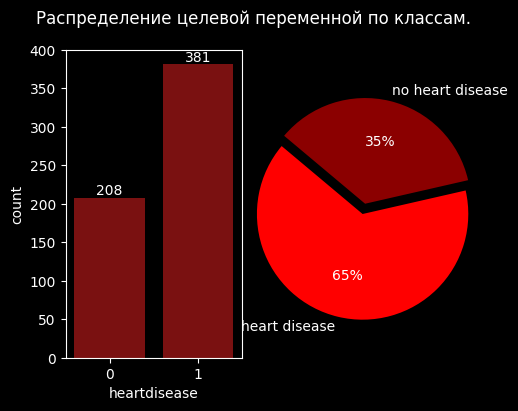

In [23]:
pig, ax = plt.subplots(1, 2)
plt.suptitle("Распределение целевой переменной по классам.")
sns.countplot(x=df_train.heartdisease, color="darkred", stat="count", ax=ax[0])
ax[0].bar_label(ax[0].containers[0])
ax[1] = plt.pie(
    df_train.heartdisease.value_counts(),
    radius=1.5,
    autopct="%.0f%%",
    colors=["red", "darkred"],
    labels=['heart disease','no heart disease'],
    startangle=140,
    explode=(0.15, 0)
)
plt.show()

Классы несколько разбалансированы, будем использовать балансировку внутри моделей.

In [24]:
pd.DataFrame(df_train.corr(numeric_only=True)['heartdisease']).style.background_gradient(cmap='autumn')

,heartdisease
age,0.249890
restingbp,0.084532
cholesterol,0.115754
fastingbs,0.281518
maxhr,-0.399714
oldpeak,0.351456
heartdisease,1.000000


Целевой признак имеет слабую корреляцию с признаками: age, fastingbs, maxhr, oldpeak.

interval columns not set, guessing: ['age', 'restingbp', 'cholesterol', 'fastingbs', 'maxhr', 'oldpeak', 'heartdisease']


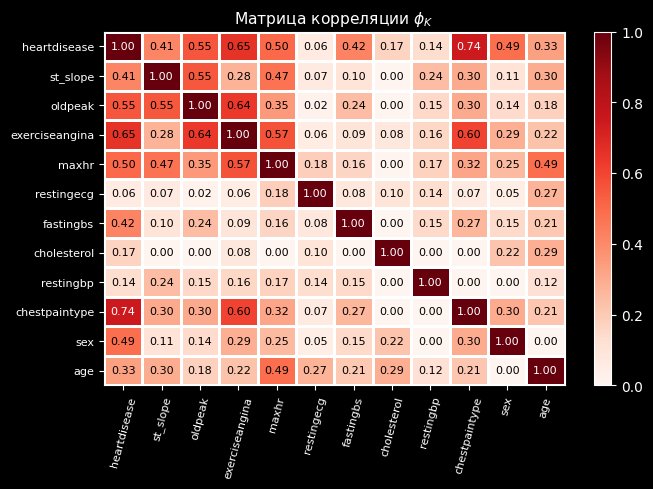

In [25]:
phik_overview = df_train.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map="Reds",
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=0.8,
)
plt.xticks(rotation=75)
plt.show()

Вывод:
1. В столбцах нет пропусков;
2. Столбец sex содержит 2 значения, мужчин больше (80%);
3. chestpaintype содержит 4 значения, из них самое частое: ASY (59%);
4. restingecg содержит 3 значения, самое частое: Normal (58%);
5. exerciseangina содержит 2 значения;
6. st_slope содержит 3 значения, самое частое Flat встречается также часто (55% ), как и в предыдущем столбце;
7. у ряда признаков средняя корреляция друг с другом:
- oldpeak - exersizeangina
- stslope - maxhr
- maxhr - exersizeangina
- age - maxhr
- chestpaintype - exersizeangina

## Предобработка данных

Удалим дубликаты.

In [26]:
print(f"Количество дубликатов: {df_train[df_train.duplicated()].shape[0]}")
df_train = df_train.drop_duplicates().reset_index(drop=True)

Количество дубликатов: 0


Отделим целевую переменную.

In [27]:
X = df_train.drop(columns='heartdisease')
y = df_train['heartdisease']

##### Заполнение пропусков

<Axes: >

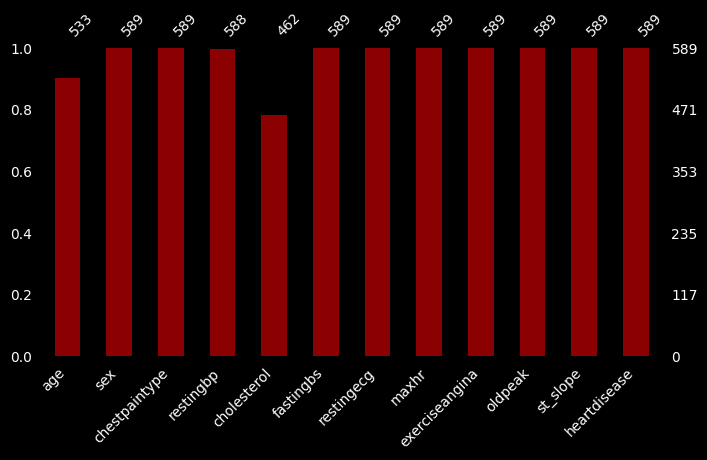

In [28]:
msno.bar(df_train, color='darkred', figsize=(8,4), fontsize=10)

In [29]:
miss_columns = [col for col in X.columns if X[col].isnull().any()]
X[miss_columns].isna().sum()

age             56
restingbp        1
cholesterol    127
dtype: int64

In [30]:
X.loc[X.restingbp.isna()]

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope
232,55.0,M,NAP,NaN,NaN,0,Normal,155,N,1.5,Flat


Одно значение можно заполнить медианой.

In [31]:
X.age.value_counts(bins=5)

(47.6, 57.4]     197
(57.4, 67.2]     178
(37.8, 47.6]      93
(67.2, 77.0]      35
(27.95, 37.8]     30
Name: age, dtype: int64

Предположим, что между возрастом и давлением есть корреляция.\
Н0: связи нет,\
Н1: связь есть

In [32]:
correlation, pvalue = stats.pearsonr(
    X.loc[(X.age.notna() & X.restingbp.notna())].age,
    X.loc[(X.age.notna() & X.restingbp.notna())].restingbp,
)
print(f"Корреляция между age и restingbp равна: {correlation:.5f}, p: {pvalue:.15f}")
alpha = 0.05
print("Отклоняем H0") if pvalue < alpha else print("Подтверждается H0")

Корреляция между age и restingbp равна: 0.29477, p: 0.000000000003984
Отклоняем H0


Поле age можно заполнить на основании давления.

Холестерин согласно матрице корреляции связан только с 2мя признаками: пол и возраст.\
Заменим пропуски на их основании, объединив их в группы.\
Если какие-то пропуски останутся, то их заменим средним.

Попробуем заменить пропуски в cholesterol и посмотреть, что получится.

In [33]:
X["age_cut"] = pd.cut(X.age, 10).apply(lambda x: str(x))
grouped = X.groupby(["age_cut", "sex"], as_index=False).agg(
    median_cholesterol=("cholesterol", "median")
)
grouped["age_sex"] = grouped.sex + grouped.age_cut.astype("object")
X.drop(columns=['age_cut'], inplace=True)

In [34]:
def bins_tranform(elem):
    result = elem[1:].strip(']').strip('(').split(',')
    return float(result[0]), float(result[1])

In [35]:
X_copy = X.copy()
for el in grouped["age_sex"]:
    low_bound, high_bound = bins_tranform(el)
    X_copy.loc[
        (X_copy.sex == el[0])
        & (X_copy.age < high_bound)
        & (X_copy.age >= low_bound)
        & (X_copy.cholesterol.isna()),
        "cholesterol",
    ] = grouped.loc[grouped.age_sex == el, "median_cholesterol"].values[0]
X_copy.cholesterol.isna().sum()

14

<Axes: xlabel='cholesterol', ylabel='Count'>

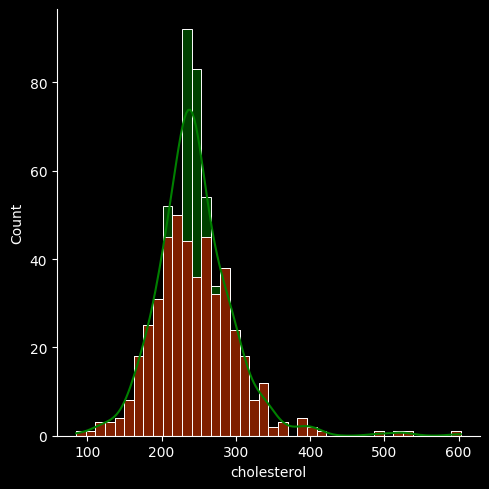

In [36]:
bins = 40
sns.displot(X_copy.cholesterol, alpha=.5, color='g', bins=bins, kde=True)
sns.histplot(df_train.cholesterol, color='red', alpha=.5, bins=bins)

Получившееся распределение больше похоже на нормальное.\
Напишем это преобразвание в отдельном классе.

In [37]:
# группировки для работы с классом, написаны не в init, так как делим потом на фолды
grouped_age = X.groupby(["restingbp"], as_index=False).agg(median_age=("age", "median"))

X["age_cut"] = pd.cut(X.age, 10).apply(lambda x: str(x))
grouped_cholesterol = X.groupby(["age_cut", "sex"], as_index=False).agg(
    median_cholesterol=("cholesterol", "median")
)
X.drop(columns=['age_cut'], inplace=True)
grouped_cholesterol["age_sex"] = (
    grouped_cholesterol.sex + grouped_cholesterol.age_cut.astype("object")
)

Подготовим класс для заполнения пропусков в столбцах age, restingbp и cholesterol.\
Также в нем проведем кодирование столбца sex (так как это удобнее для columns transformer)

In [38]:
class SpecialImputer(TransformerMixin, BaseEstimator, OneToOneFeatureMixin):
    """Class imputer for num features"""

    def __init__(self, grouped_age, grouped_cholesterol):
        self.grouped_age = grouped_age
        self.grouped_cholesterol = grouped_cholesterol

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X) -> pd.DataFrame:
        for el in grouped_cholesterol["age_sex"]:
            low_bound, high_bound = bins_tranform(el)
            X.loc[
                (X.sex == el[0])
                & (X.age < high_bound)
                & (X.age >= low_bound)
                & (X.cholesterol.isna()),
                "cholesterol",
            ] = grouped_cholesterol.loc[
                grouped_cholesterol.age_sex == el, "median_cholesterol"
            ].values[0]
        dct = {'M':0, 'F':1}
        X['sex'] = X['sex'].map(dct)
        X = X.fillna(X.median(numeric_only=True))
        return X

    def bins_tranform(elem) -> tuple:
        result = elem[1:].strip("]").strip("(").split(",")
        return float(result[0]), float(result[1])

Напишем функцию для преобразования столбцов в нижний регистр,\
так как это удобнее для работы с данными.

In [39]:
def columns2lower(X):
    """Function for get lower names of columns"""
    X.columns = X.columns.str.lower()
    return X

Разделим данные на обучающую и валидационную выборки.

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123, test_size=0.2)

In [41]:
X_train.shape, y_train.shape

((471, 11), (471,))

#### Построение модели.

In [42]:
# зададим параметры 
cv = StratifiedKFold(n_splits=5)
scoring = 'roc_auc'
estimators = (50, 151, 50)

In [43]:
pipe = Pipeline(
    [
        ("columns lower", FunctionTransformer(columns2lower, feature_names_out='one-to-one')),
        (
            "preproc",
            ColumnTransformer(
                transformers=[
                    (
                        "special transformer",
                        SpecialImputer(grouped_age, grouped_cholesterol),
                        ["restingbp", "age", "sex", "cholesterol"],
                    ),
                    (
                        "encoder_cat",
                        OneHotEncoder(drop="first"),
                        ["chestpaintype", "restingecg", "exerciseangina", "st_slope"],
                    ),
                ]
            ),
        ),
        ("scaler", StandardScaler()),
        (
            "clf",
            None,
        ),
    ]
)
models = [
    {
        "clf": (
            LogisticRegression(
                solver="liblinear", random_state=123, class_weight="balanced"
            ),
        ),
        "clf__C": (1, 10),
    },
    {
        "clf": (RandomForestClassifier(random_state=123, class_weight="balanced"),),
        "clf__max_depth": [2, 4, 7],
        "clf__min_samples_leaf": (1, 6, 2),
        "clf__min_samples_split": (2, 8, 2),
        "clf__n_estimators": estimators,
    },
    {
        "clf": (XGBClassifier(random_state=123),),
        "clf__max_depth": (5, 16, 5),
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__n_estimators": estimators,
    },
]

params = [{**model} for model in models]
grid_search = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=scoring, n_jobs=-1)

In [44]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columns lower',
                                        FunctionTransformer(feature_names_out='one-to-one',
                                                            func=<function columns2lower at 0x71313cae9e10>)),
                                       ('preproc',
                                        ColumnTransformer(transformers=[('special '
                                                                         'transformer',
                                                                         SpecialImputer(grouped_age=    restingbp  median_age
0        80.0         NaN
1        92.0        38.0
2        94....
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=None, n_jobs=None,
                                                num_parallel_tree=None,
                                                random_state=123, ...),),
                          'clf__learning_rate': [0.01, 0.05, 0.1],
                          'clf__max_depth': (5, 16, 5),
                          'clf__n_estimators': (50, 151, 50)}],
             scoring='roc_auc')

In [45]:
y_pred_train = grid_search.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_train)
print(
    f"Качество модели на обучающей выборке: {round(roc_auc, 6)}",
)

Качество модели на обучающей выборке: 0.980325


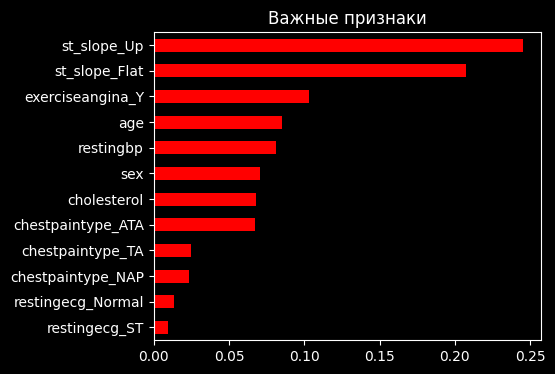

In [46]:
# Выбор важных признаков
feature_importances = pd.Series(
    grid_search.best_estimator_[3].feature_importances_,
    index=[
        x.split("__")[-1]
        for x in grid_search.best_estimator_[1].get_feature_names_out()
    ],
).sort_values(ascending=True)
plt.title("Важные признаки")
feature_importances.plot(kind="barh", **param_plt)
plt.show()

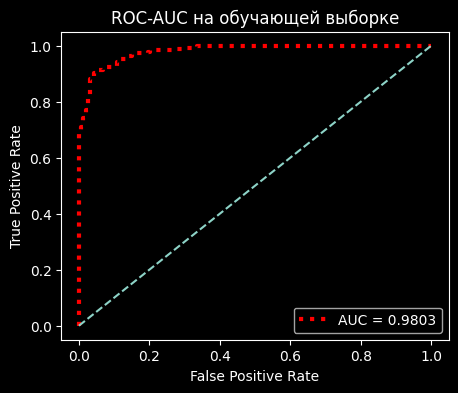

In [47]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
plt.title('ROC-AUC на обучающей выборке')
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", **param_plt)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [48]:
pd.DataFrame(
    classification_report(y_train, grid_search.predict(X_train), output_dict=True)
)

,0,1,accuracy,macro avg,weighted avg
precision,0.855422,0.947541,0.915074,0.901481,0.916639
recall,0.898734,0.923323,0.915074,0.911028,0.915074
f1-score,0.876543,0.935275,0.915074,0.905909,0.915573
support,158.000000,313.000000,0.915074,471.000000,471.000000


In [49]:
grid_search.best_params_

{'clf': RandomForestClassifier(class_weight='balanced', random_state=123),
 'clf__max_depth': 7,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 8,
 'clf__n_estimators': 151}

In [50]:
# pd.DataFrame.from_dict(grid_search.cv_results_).transpose()

In [51]:
y_pred_val = grid_search.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_val)
print(
    f"Качество модели на валидационной выборке: {round(roc_auc_val, 6)}",
)

Качество модели на валидационной выборке: 0.911765


In [52]:
X_test = df_test.drop(columns='HeartDisease')
y_test = df_test['HeartDisease']
y_pred_test = grid_search.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print(
    f"Качество модели на тестовой выборке: {round(roc_auc_test, 6)}",
)

Качество модели на тестовой выборке: 0.889989


In [53]:
pd.DataFrame(
    classification_report(y_test, grid_search.predict(X_test), output_dict=True)
)

,0,1,accuracy,macro avg,weighted avg
precision,0.770270,0.894309,0.847716,0.832290,0.850234
recall,0.814286,0.866142,0.847716,0.840214,0.847716
f1-score,0.791667,0.880000,0.847716,0.835833,0.848613
support,70.000000,127.000000,0.847716,197.000000,197.000000


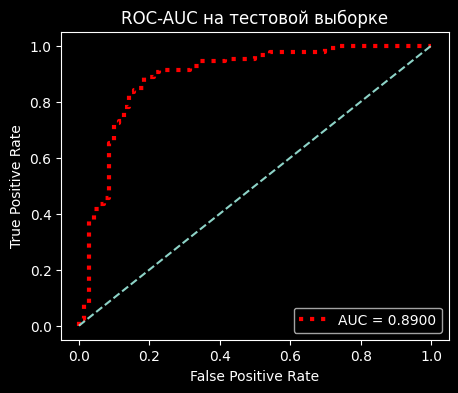

In [54]:
fpr, tpr, thresholds_ = roc_curve(y_test, y_pred_test)
plt.title("ROC-AUC на тестовой выборке")
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_test:.4f}", **param_plt)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-warning">

**Вывод:**
</br>
Лучший результат ROC-AUC = 0.8900 на тестовых данных показала модель RandomForestClassifier с параметрами:
- max_depth: 7,
- min_samples_leaf: 1,
- min_samples_split: 8,
- n_estimators: 151.

В пайплайне были заполнены пропуски, преобразованы категориальные признаки и выбрана лучшая модель.
Самые важные признаки, выделенные моделью, связаны с болью в груди.